# CSCI 4962 Final Project: Satellite Image Weather Classification

TO-DO
- Dataset augmentation (specifically image rotation, changing brightness etc)
- Train / test / val split (Steven L.)
- Choosing pre-built models
- Developing our own model + intuition

# Data Set

Our dataset consists mainly of 2 image folders indicating the years in which these images were taken, 2018 and 2019. Which is then further separated into the general areas of the world they took place in, such as the East Pacific, Central Pacific, and Atlantic. This data either shows weather images displaying a hurricane or just regular weather that can be cloud formations or other weather phenomena such as dust storms. Using this data we want to be able to develop a model that could classify whether an image is displaying a hurricane or not.

In [ ]:
import re
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to folders in google drive
model_dir = '/content/drive/MyDrive/Machine Learning Projects/Final Project/'
dataset_dir = model_dir + 'Data/'

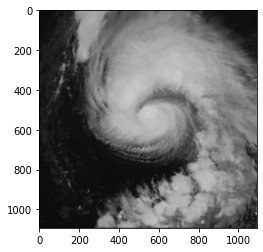

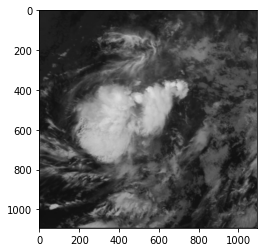

In [ ]:
# Display sample images
plt.imshow(mpimg.imread(
    dataset_dir + 'train/2018/atlantic/al162018/al162018_goes16_20181030T142056_85_29.51N_57.73W.jpg'
))
plt.show()
plt.imshow(mpimg.imread(
    dataset_dir + 'train/2019/east_pacific/ep052019/ep052019_goes13_20190722T081528_30_15.04N_116.24W.jpg'
))
plt.show()

In [ ]:
def get_filenames(root):
  return [
         os.path.join(dir, fname)
         for dir, _, fnames in os.walk(root)
         for fname in fnames
  ]
def get_wind_speed_from_filename(fname):
    return int(re.match(r'^.*_goes[^_]+_[^_]+_([^_]+)_.*$', fname).group(1))
def get_wind_speed_labels(files):
  return [
         get_wind_speed_from_filename(fname)
         for fname in files
  ]

In [ ]:
# # DO NOT RUN AGAIN, TAKES 1+ HRS

# # Train / validation / test split
# dVal = 0.10
# dTest = 0.05

# # Choose an approximately uniform distribution of wind speeds for test and validation set
# files = get_filenames(dataset_dir + 'Dataset_Hurricane')
# n = len(files)
# wind_speeds = get_wind_speed_labels(files)
# speed_buckets = {
#     speed: [
#             fname for fname, fspeed in zip(files, wind_speeds)
#             if fspeed == speed
#     ]
#     for speed in set(wind_speeds)
# }
# nVal = int(dVal * n)
# nTest = int(dTest * n)
# nTrain = n - nVal - nTest
# def sample_uniform(nSample):
#   sample = []
#   for _ in range(nSample):
#     speed, bucket = random.choice(list(speed_buckets.items()))
#     fname = random.choice(bucket)
#     sample.append(fname)
#     bucket.remove(fname)
#     if not bucket: del speed_buckets[speed]
#   return sample
# test_files = sample_uniform(nTest)
# val_files = sample_uniform(nVal)
# train_files = [fname for bucket in speed_buckets.values() for fname in bucket]

# # Copy files to train, test, and val folders
# def copyfile(src, dest):
#   os.makedirs(dest.rsplit('/', 1)[0], exist_ok=True)
#   shutil.copyfile(src, dest)
# for fname in train_files:
#   copyfile(fname, fname.replace('Dataset_Hurricane', 'train', 1))
# for fname in val_files:
#   copyfile(fname, fname.replace('Dataset_Hurricane', 'validation', 1))
# for fname in test_files:
#   copyfile(fname, fname.replace('Dataset_Hurricane', 'test', 1))

In [ ]:
# # Find corrupted files
# from os import listdir
# from PIL import Image
# files = get_filenames(dataset_dir + 'train')
# for filename in files:
#     try:
#       img = Image.open(filename) # open the image file
#       img.verify() # verify that it is, in fact an image
#     except (IOError, SyntaxError) as e:
#       print('Bad file:', filename) # print out the names of corrupt files

In [ ]:
# Load the training set
train = keras.utils.image_dataset_from_directory(
    directory=dataset_dir + 'train',
    labels=get_wind_speed_labels(get_filenames(dataset_dir + 'train')),
    color_mode='grayscale', image_size=(256, 256)
)
# Load the validation set
val = keras.utils.image_dataset_from_directory(
    directory=dataset_dir + 'validation',
    labels=get_wind_speed_labels(get_filenames(dataset_dir + 'validation')),
    color_mode='grayscale', image_size=(256, 256)
)
# Load the testing set
test = keras.utils.image_dataset_from_directory(
    directory=dataset_dir + 'test',
    labels=get_wind_speed_labels(get_filenames(dataset_dir + 'test')),
    color_mode='grayscale', image_size=(256, 256)
)

Found 5869 files belonging to 2 classes.
Found 689 files belonging to 2 classes.
Found 344 files belonging to 2 classes.


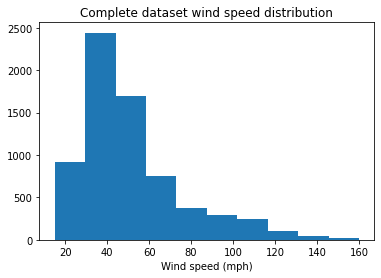

In [ ]:
plt.hist(get_wind_speed_labels(get_filenames(dataset_dir + 'Dataset_Hurricane')))
plt.title('Complete dataset wind speed distribution')
plt.xlabel('Wind speed (mph)')
plt.show()

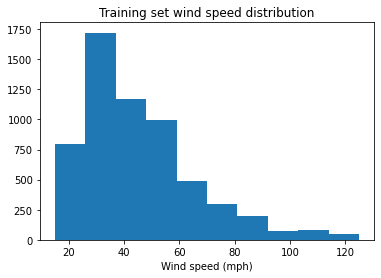

In [ ]:
plt.hist(get_wind_speed_labels(get_filenames(dataset_dir + 'train')))
plt.title('Training set wind speed distribution')
plt.xlabel('Wind speed (mph)')
plt.show()

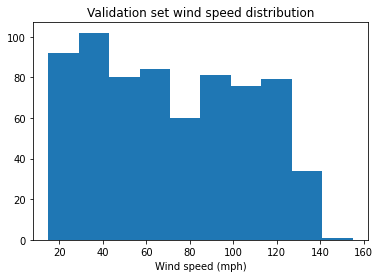

In [ ]:
plt.hist(get_wind_speed_labels(get_filenames(dataset_dir + 'validation')))
plt.title('Validation set wind speed distribution')
plt.xlabel('Wind speed (mph)')
plt.show()

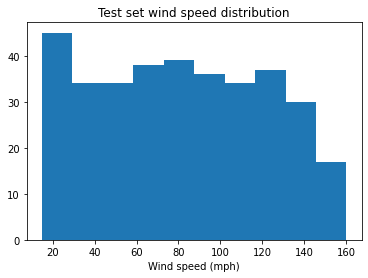

In [ ]:
plt.hist(get_wind_speed_labels(get_filenames(dataset_dir + 'test')))
plt.title('Test set wind speed distribution')
plt.xlabel('Wind speed (mph)')
plt.show()

# Sample weights

In [ ]:
from sklearn.utils import class_weight
files = get_filenames(dataset_dir + 'train')
labels = get_wind_speed_labels(files)
speeds = list(set(labels))
weights = class_weight.compute_class_weight('balanced', classes=speeds, y=labels)
speed_weights = dict(zip(speeds, weights))
def weightGen():
  for img, speed in train.unbatch():
    yield img, speed, speed_weights[int(speed)]
train_weighted = tf.data.Dataset.from_generator(
    weightGen,
    output_signature=(
        *map(lambda x: tf.TensorSpec(x.shape[1:], x.dtype), train.element_spec),
        tf.TensorSpec((), tf.float32)
    )
).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

{15: 8.892424242424243, 20: 1.3610853432282004, 25: 0.4688448633967087, 30: 0.31020084566596196, 35: 0.31020084566596196, 40: 0.4544680192039647, 45: 0.45916132060710374, 50: 0.5466654247391952, 55: 0.5230837789661319, 60: 0.8633421594586643, 65: 1.498723186925434, 70: 1.9192282537606278, 75: 2.6154188948306594, 80: 4.680223285486443, 85: 2.899703557312253, 90: 2.590026478375993, 95: 7.6220779220779225, 100: 6.506651884700665, 105: 4.373323397913562, 110: 12.703463203463203, 115: 5.676015473887814, 125: 88.92424242424242}


# Data Augmentation

**Data augmentation**
- Rotation (full rotation)
- Brightness adjustment
- Random noise (not a lot)
- Image cutout
- Random zoom
- Random translation

## Option 1

In [ ]:
# Maybe like this?
flattened = list(train_weighted.unbatch())
ALL_IMG = tf.convert_to_tensor([data[0] for data in flattened])
ALL_LABELS = tf.convert_to_tensor([data[1] for data in flattened])
ALL_WEIGHTS = tf.convert_to_tensor([data[2] for data in flattened])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    fill_mode='constant',
    rotation_range=360,
    zoom_range=(0.9, 1.1),
    shear_range=0.10,
    brightness_range=(.80, 1.15)
)
datagen.fit(ALL_IMG)
train_aug = datagen.flow(
    ALL_IMG, ALL_LABELS, batch_size=32, sample_weight=ALL_WEIGHTS
)
train_aug_epoch_size = 184
# Generator yields (image, wind_speed, weight) batches

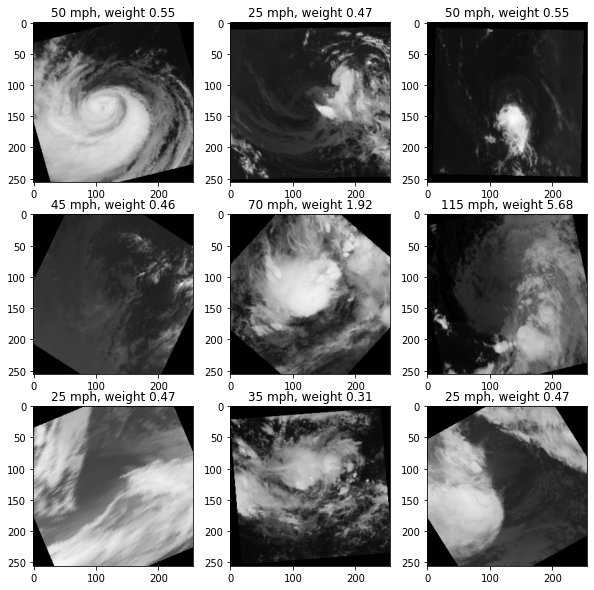

In [ ]:
# Test generator
X, y, w = next(train_aug)
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(tf.reshape(X[i], X[i].shape[:-1]), cmap='gray', vmin=0, vmax=255)
  plt.title('{} mph, weight {:.2f}'.format(y[i], w[i]))

## Option 2

In [ ]:
# import numpy as np
# import IPython.display as display 
# from PIL import Image
# import matplotlib.pyplot as plt
# import glob
# # https://github.com/tensorflow/tensorflow/issues/40188

# # !pip install tf-nightly --quiet

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import preprocessing

# data_augmentation = keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip('horizontal'),
#   layers.experimental.preprocessing.RandomRotation(1.0),
#   layers.experimental.preprocessing.RandomTranslation((0.2, 0.5),(0.2, 0.5)),
#   layers.experimental.preprocessing.RandomZoom((0.2, 0.5),(0.2, 0.5)),
#   layers.experimental.preprocessing.RandomContrast(0.5),
# ])

# train_ds = train.prefetch(buffer_size=32)
# validation_ds = val.prefetch(buffer_size=32)
# aug_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights=None, input_shape=(256, 256, 1))
# image_size = (256,256)
# def make_model(input_shape):
#   inputs = keras.Input(shape=input_shape)
#   # Image augmentation block
#   x = data_augmentation(inputs)

#   # Entry block
#   x = layers.experimental.preprocessing.Rescaling(1./255)(x)
#   x = aug_model(x)

#   previous_block_activation = x  # Set aside residual

#   x = layers.GlobalAveragePooling2D()(x)
#   activation = 'softmax'
#   units = 1
  
#   x = layers.Dropout(0.5)(x)
#   outputs = layers.Dense(units, activation=activation)(x)
#   return keras.Model(inputs, outputs)

# aug_model = make_model(input_shape=image_size)
# keras.utils.plot_model(aug_model, show_shapes=True)

In [ ]:
# tf.autograph.experimental.do_not_convert(
#     func=None
# )
# epochs = 2
# aug_model.compile(optimizer=keras.optimizers.Adam(1e-3),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# aug_model.fit(train_ds, epochs=epochs, validation_data=validation_ds, verbose=1)

# Model 1

Use a custom Convolutional Neural Network model with one densely connected layer for regression

In [ ]:
# Regression model 1

model1 = keras.Sequential((
    layers.Input(shape=(256, 256, 1)),
    layers.Rescaling(1./255),
    layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(rate=0.2),
    layers.Dense(units=1),
    layers.Rescaling(240.)
), name='model1')
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_99 (Conv2D)          (None, 128, 128, 32)      544       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_100 (Conv2D)         (None, 64, 64, 64)        32832     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_101 (Conv2D)         (None, 32, 32, 64)        65600     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 64)        0    

In [ ]:
model1.load_weights(model_dir + 'model1.h5')

In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate=1e-6, beta_1=0.9, beta_2=0.999
)
model1.compile(
    optimizer=optimizer, loss='mse',
    metrics=(
        'mean_squared_error',
        'mean_absolute_error',
        'mean_absolute_percentage_error'
    )
)

In [ ]:
history = model1.fit(
    train_aug, steps_per_epoch=train_aug_epoch_size,
    epochs=2
)
model1.save_weights(model_dir + 'model1.h5')

Epoch 1/2
184/184 [==============================] - 36s 196ms/step - loss: 1024.1219 - mean_squared_error: 809.4793 - mean_absolute_error: 25.4168 - mean_absolute_percentage_error: 74.8091
Epoch 2/2
184/184 [==============================] - 36s 196ms/step - loss: 1021.5302 - mean_squared_error: 825.0938 - mean_absolute_error: 25.7020 - mean_absolute_percentage_error: 75.6492


In [ ]:
val_results = model1.evaluate(val)

22/22 [==============================] - 3s 97ms/step - loss: 1266.9872 - mean_squared_error: 1266.9872 - mean_absolute_error: 30.7035 - mean_absolute_percentage_error: 68.0718


## Model 2

Using the InceptionV3 classifier model for regression.

In [ ]:
# Classifier model 2 (InceptionV3)

inception = keras.applications.InceptionV3(
      weights=None,
      input_tensor=keras.applications.inception_v3.preprocess_input(
          layers.Input(shape=(256, 256, 1))
      ),
      classes=1,
      classifier_activation=None,
)

model2 = keras.Sequential((
    inception,
    layers.Rescaling(240.)
))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1)                 21804257  
                                                                 
 rescaling (Rescaling)       (None, 1)                 0         
                                                                 
Total params: 21,804,257
Trainable params: 21,769,825
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model2.load_weights(model_dir + 'model2.h5')

In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate=1e-7, beta_1=0.9, beta_2=0.999
)
model2.compile(
    optimizer=optimizer, loss='mse',
    metrics=(
        'mean_squared_error',
        'mean_absolute_error',
        'mean_absolute_percentage_error'
    )
)

In [ ]:
history = model2.fit(
    train_aug, steps_per_epoch=train_aug_epoch_size,
    epochs=1
)
model2.save_weights(model_dir + 'model2.h5')

184/184 [==============================] - 180s 930ms/step - loss: 896.8578 - mean_squared_error: 802.7294 - mean_absolute_error: 24.6119 - mean_absolute_percentage_error: 72.3851


In [ ]:
val_results = model2.evaluate(val)

22/22 [==============================] - 9s 291ms/step - loss: 1407.8798 - mean_squared_error: 1407.8798 - mean_absolute_error: 31.9595 - mean_absolute_percentage_error: 65.6191


## Model 3

Using the MobileNetV2 classifier model for regression.

In [ ]:
# Classifier model 2 (MobileNetV2)

mobile = keras.applications.MobileNetV2(
      weights=None,
      input_tensor=keras.applications.mobilenet_v2.preprocess_input(
          layers.Input(shape=(256, 256, 1))
      ),
      classes=1,
      classifier_activation=None,
)

model3 = keras.Sequential((
    mobile,
    layers.Rescaling(240.)
))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1)                2258689   
 ional)                                                          
                                                                 
 rescaling_6 (Rescaling)     (None, 1)                 0         
                                                                 
Total params: 2,258,689
Trainable params: 2,224,577
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model3.load_weights(model_dir + 'model3.h5')

In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate=1e-4, beta_1=0.9, beta_2=0.999
)
model3.compile(
    optimizer=optimizer, loss='mse',
    metrics=(
        'mean_squared_error',
        'mean_absolute_error',
        'mean_absolute_percentage_error'
    )
)

In [ ]:
history = model3.fit(
    train_aug, steps_per_epoch=train_aug_epoch_size,
    epochs=1
)
model3.save_weights(model_dir + 'model3.h5')

184/184 [==============================] - 108s 585ms/step - loss: 1120.9982 - mean_squared_error: 1064.0662 - mean_absolute_error: 27.4233 - mean_absolute_percentage_error: 78.8420


In [ ]:
val_results = model3.evaluate(val)

22/22 [==============================] - 6s 216ms/step - loss: 1314.4464 - mean_squared_error: 1314.4464 - mean_absolute_error: 31.2251 - mean_absolute_percentage_error: 79.6151


# Model Evaluation

In [ ]:
ALL_TEST = list(test.unbatch())
ALL_TEST_IMG = tf.convert_to_tensor([data[0] for data in flattened])
ALL_TEST_LABELS = tf.convert_to_tensor([data[1] for data in flattened])

## Model 1

In [ ]:
val_results_1 = model1.evaluate(val)
yHat_1 = model1.predict(ALL_TEST_IMG)

22/22 [==============================] - 5s 182ms/step - loss: 1266.9871 - mean_squared_error: 1266.9871 - mean_absolute_error: 30.7035 - mean_absolute_percentage_error: 68.0718


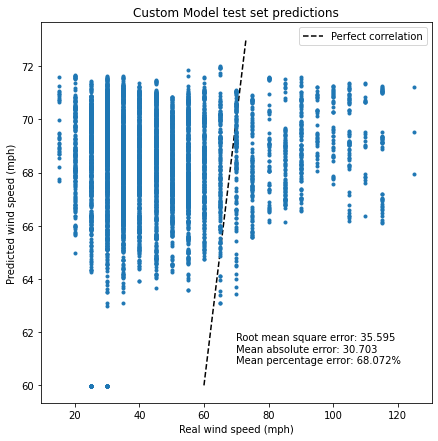

In [ ]:
plt.figure(figsize=(7,7))
lims = (60, 73)
plt.plot(lims, lims, 'k--', label='Perfect correlation')
plt.plot(ALL_TEST_LABELS, yHat_1, '.')
plt.title('Custom Model test set predictions')
plt.xlabel('Real wind speed (mph)')
plt.ylabel('Predicted wind speed (mph)')
plt.legend()
plt.text(70, 62,
    'Root mean square error: {:.3f}\n'.format(tf.sqrt(val_results_1[1]))
    + 'Mean absolute error: {:.3f}\n'.format(val_results_1[2])
    + 'Mean percentage error: {:.3f}%\n'.format(val_results_1[3]),
    va='top'
)
plt.show()

## Model 2

In [ ]:
val_results_2 = model2.evaluate(val)
yHat_2 = model2.predict(ALL_TEST_IMG)

22/22 [==============================] - 9s 321ms/step - loss: 1407.8798 - mean_squared_error: 1407.8798 - mean_absolute_error: 31.9595 - mean_absolute_percentage_error: 65.6191


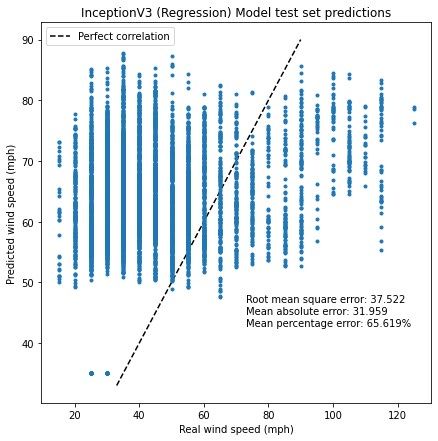

In [ ]:
plt.figure(figsize=(7,7))
lims = (33, 90)
plt.plot(lims, lims, 'k--', label='Perfect correlation')
plt.plot(ALL_TEST_LABELS, yHat_2, '.')
plt.title('InceptionV3 (Regression) Model test set predictions')
plt.xlabel('Real wind speed (mph)')
plt.ylabel('Predicted wind speed (mph)')
plt.legend()
plt.text(73, 48,
    'Root mean square error: {:.3f}\n'.format(tf.sqrt(val_results_2[1]))
    + 'Mean absolute error: {:.3f}\n'.format(val_results_2[2])
    + 'Mean percentage error: {:.3f}%\n'.format(val_results_2[3]),
    va='top'
)
plt.show()

## Model 3

In [ ]:
val_results_3 = model3.evaluate(val)
yHat_3 = model3.predict(ALL_TEST_IMG)

22/22 [==============================] - 5s 198ms/step - loss: 1314.4467 - mean_squared_error: 1314.4467 - mean_absolute_error: 31.2251 - mean_absolute_percentage_error: 79.6151


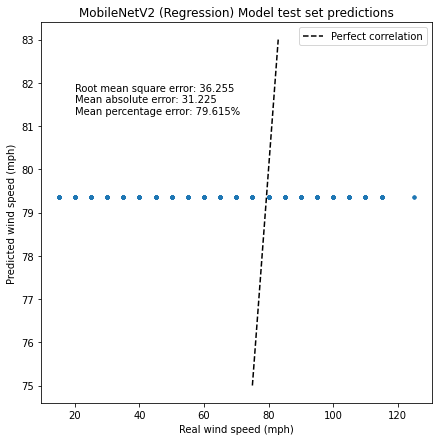

In [ ]:
plt.figure(figsize=(7,7))
lims = (75, 83)
plt.plot(lims, lims, 'k--', label='Perfect correlation')
plt.plot(ALL_TEST_LABELS, yHat_3, '.')
plt.title('MobileNetV2 (Regression) Model test set predictions')
plt.xlabel('Real wind speed (mph)')
plt.ylabel('Predicted wind speed (mph)')
plt.legend()
plt.text(20, 82,
    'Root mean square error: {:.3f}\n'.format(tf.sqrt(val_results_3[1]))
    + 'Mean absolute error: {:.3f}\n'.format(val_results_3[2])
    + 'Mean percentage error: {:.3f}%\n'.format(val_results_3[3]),
    va='top'
)
plt.show()